# Catch 'Em All: Predicting Legendary Pokemons

Bu notebook'ta, 800'den fazla Pokemon'un savaş istatistiklerini (HP, Attack, Speed vb.) ve element türlerini inceleyerek bir Pokemon'un **Efsanevi (Legendary)** olup olmadığını tahmin edeceğiz. 

### What We Are Going to Do?
Kaggle'daki standart çözümlerin aksine bu projede şu "Faz 1" yeteneklerimizi öne çıkaracağız:
1. **Advanced EDA:** Efsanevi Pokemonların genetiğini görselleştirme.
2. **Feature Engineering (Özellik Mühendisliği):** Element tiplerini (Type 1 & 2) makinenin anlayacağı dile çevirme ve yeni "Güç Çarpanları" üretme.
3. **Tree Algorithms:** Decision Tree (Karar Ağacı) ile "20 Soru Oyununu" görselleştirme ve Random Forest ile performansı zirveye taşıma.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import kagglehub

# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")

print("Path to dataset files:", path)

df = pd.read_csv(path + '/pokemon.csv')

# '#' column dropped
df = df.drop(['#'], axis=1)

print("--- Dataset Size ---")
print(df.shape)
display(df.head())

Path to dataset files: /Users/melih/.cache/kagglehub/datasets/abcsds/pokemon/versions/2
--- Dataset Size ---
(800, 12)


,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## Exploratory Data Analysis (EDA)
1. Boxplot (Legendary vs Basic)
2. Violinplot (Which Type 1 is most Legendary Pokemon?)
3. Heatmap (Character Analysis)

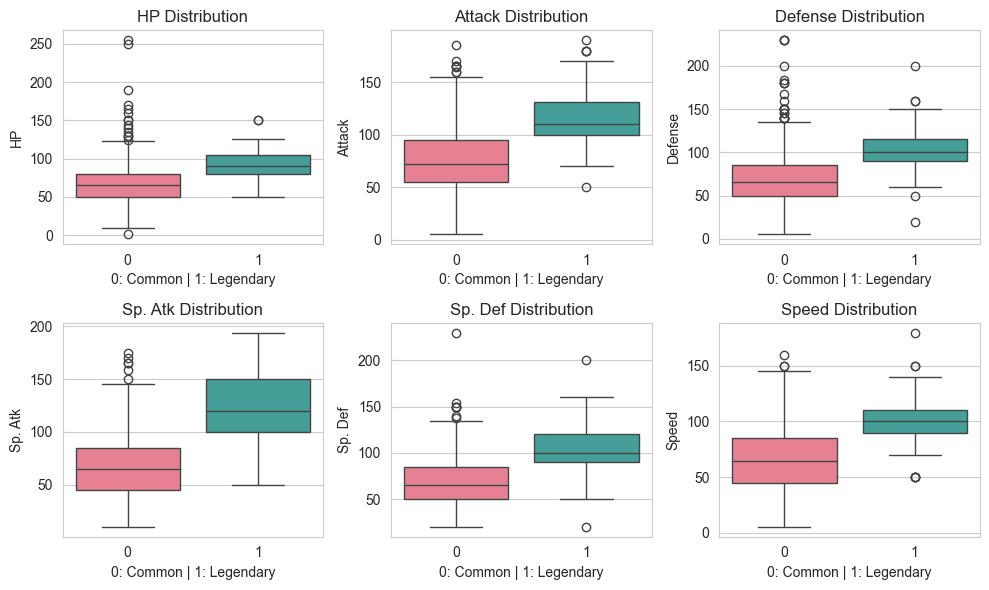

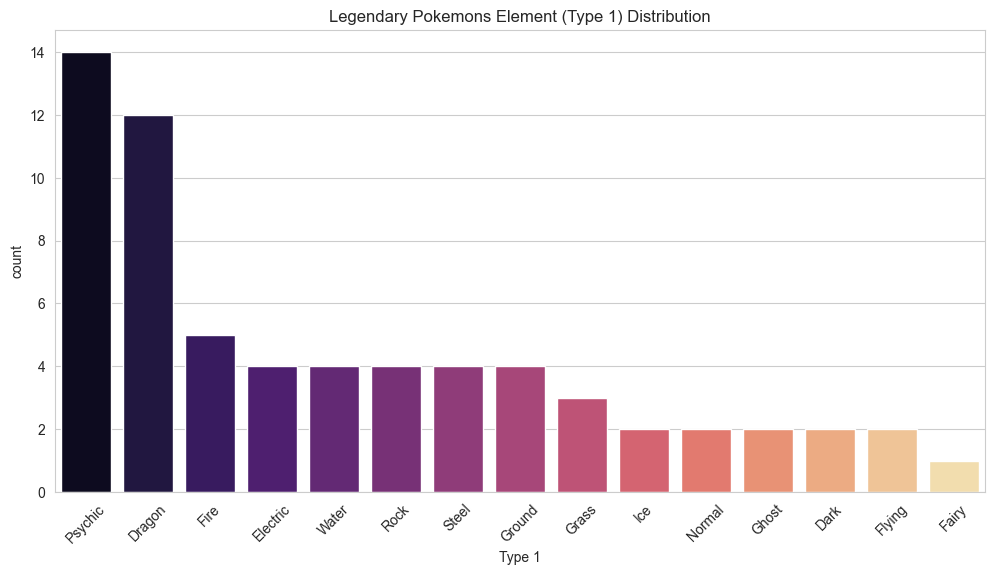

In [3]:
# Boxplot

# Legendary column will be 1/0 (True/False)
df['Legendary'] = df['Legendary'].astype(int)

# Which stat will be required 
stats = ['HP','Attack','Defense','Sp. Atk', 'Sp. Def', 'Speed']

# Visualize Boxplot
plt.figure(figsize=(10,6))
for i,stat in enumerate(stats, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Legendary', y=stat, data=df, palette='husl')
    plt.title(f"{stat} Distribution")
    plt.xlabel("0: Common | 1: Legendary")

plt.tight_layout()
plt.show()

# Violinplot

plt.figure(figsize=(12, 6))
sns.countplot(data=df[df['Legendary'] == 1], x= 'Type 1', palette = 'magma',order=df[df['Legendary'] == 1]['Type 1'].value_counts().index)
plt.title("Legendary Pokemons Element (Type 1) Distribution")
plt.xticks(rotation=45)
plt.show()

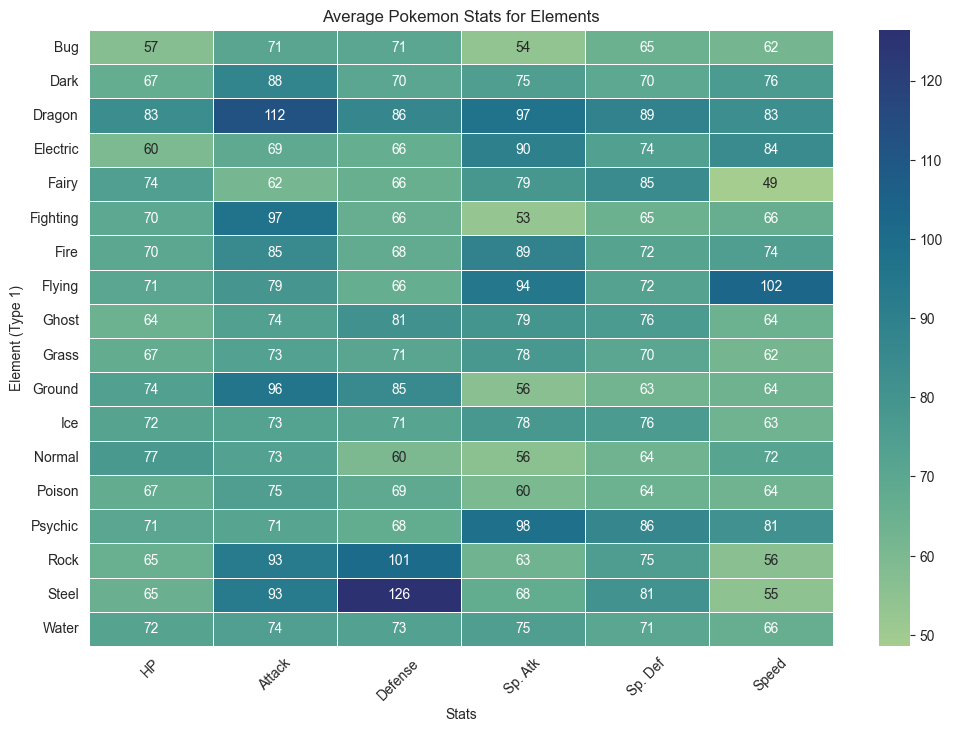

In [4]:
# Heatmap

# We will calculate mean for each element type
type_stats = df.groupby('Type 1')[['HP','Attack','Defense','Sp. Atk', 'Sp. Def', 'Speed']].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(type_stats, annot=True, cmap='crest', fmt='.0f', linewidths=0.5)
plt.title("Average Pokemon Stats for Elements")
plt.ylabel("Element (Type 1)")
plt.xlabel("Stats")
plt.xticks(rotation=45)
plt.show()

## Feature Engineering
- Total Stats: It depends on HP, Attack, Defense, Sp. Atk, Sp. Def, Speed

In [5]:
# New Feature
df['total_stats'] = df['HP'] + df['Attack'] + df['Defense'] + df['Sp. Atk'] + df['Sp. Def'] + df['Speed']

# Label Encoding
# Type 1 should be numeric
le = LabelEncoder()
df['Type 1'] = le.fit_transform(df['Type 1'])

# Type 2 have a lot of NaN so we will assign NaN to None parameter
df['Type 2'] = df['Type 2'].fillna('None')
df['Type 2'] = le.fit_transform(df['Type 2'])

# X and y Preparation
X = df[['Type 1', 'Type 2', 'HP', 'Attack', 'Sp. Atk', 'Sp. Def', 'Speed', 'total_stats']]
y = df['Legendary']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Data is waiting for model")
print(f"Train Datas: {X_train.shape[0]} Pokemon")
print(f"Test Datas: {X_test.shape[0]} Pokemon")

Data is waiting for model
Train Datas: 640 Pokemon
Test Datas: 160 Pokemon


## Modelling: Random Forest and Decision Tree
1. Random Forest -> n_estimators = 100
2. Decision Tree -> max_depth = 3

In [6]:
# Modelling

# 1. Random Forest Fitting
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 2. Decision Tree Fitting
dt_model = DecisionTreeClassifier(max_depth = 3, random_state = 42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# Performance Results for each Models
print("--- Decision Tree Performance ---")
print(f"Accuracy: %{accuracy_score(y_test, y_pred_dt)*100:.2f}")
print(classification_report(y_test, y_pred_dt))

print("\n--- Random Forest Performance ---")
print(f"Accuracy: %{accuracy_score(y_test, y_pred_rf)*100:.2f}")
print(classification_report(y_test, y_pred_rf))


--- Decision Tree Performance ---
Accuracy: %94.38
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       150
           1       0.53      0.80      0.64        10

    accuracy                           0.94       160
   macro avg       0.76      0.88      0.80       160
weighted avg       0.96      0.94      0.95       160


--- Random Forest Performance ---
Accuracy: %97.50
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       150
           1       0.75      0.90      0.82        10

    accuracy                           0.97       160
   macro avg       0.87      0.94      0.90       160
weighted avg       0.98      0.97      0.98       160



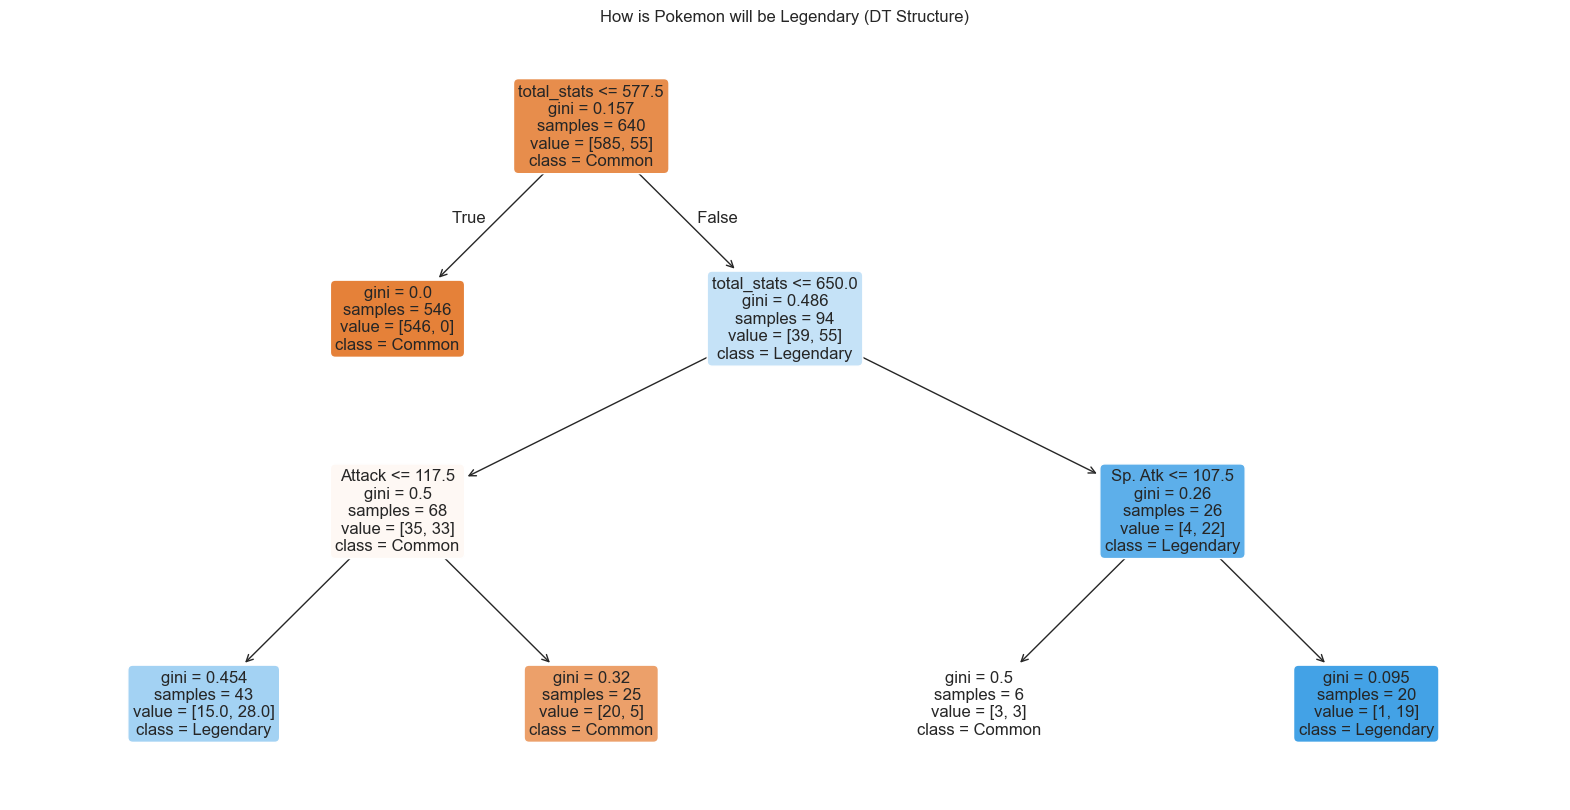

In [7]:
# Decision Tree Visualization 
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names = X.columns,
    class_names=['Common', 'Legendary'],
    filled = True,
    rounded = True,
    fontsize = 12
)
plt.title("How is Pokemon will be Legendary (DT Structure)")
plt.show()

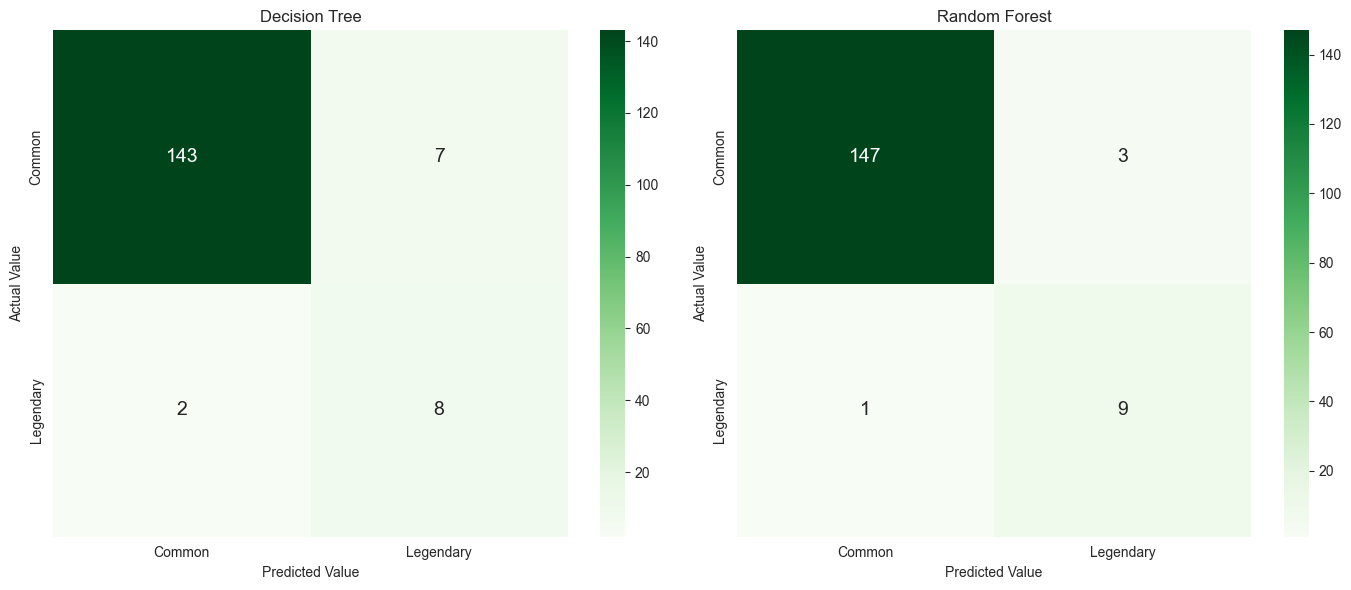

In [8]:
# Confusion Matrix Analysis

# Matrixs Calculation
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig,axes = plt.subplots(1, 2, figsize=(14, 6))

# DT Matrix
sns.heatmap(
    cm_dt,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[0],
    xticklabels=['Common', 'Legendary'],
    yticklabels=['Common', 'Legendary'],
    annot_kws={"size":14}
)
axes[0].set_title("Decision Tree")
axes[0].set_ylabel("Actual Value")
axes[0].set_xlabel("Predicted Value")

# RF Matrix
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[1],
    xticklabels=['Common', 'Legendary'],
    yticklabels=['Common', 'Legendary'],
    annot_kws={"size":14}
)
axes[1].set_title("Random Forest")
axes[1].set_ylabel("Actual Value")
axes[1].set_xlabel("Predicted Value")

plt.tight_layout()
plt.show()

##  Result and Lore Analysis (Business Insight)

Bu projede Pokemonların sadece savaş istatistiklerine bakarak **"Efsanevi" (Legendary)** olup olmadıklarını Ağaç algoritmaları ile tahmin ettik. Sonuçlar, oyunun kendi hikayesiyle (Lore) muazzam bir uyum içinde!

### Model Performances

* 🌳 **Decision Tree (Karar Ağacı):** Tek bir ağaç **%94.38** doğrulukla çalışsa da, `Precision` (Hassasiyet) değeri **%53**'te kalmıştır. 
  > *Lore Gerçeği:* Confusion Matrix'te de görüldüğü üzere ağaç, istatistikleri çok yüksek olan sıradan Pokemonları (Örn: *Dragonite, Metagross* gibi Pseudo-Legendary'leri) Efsanevi sanarak tuzağa düşmüş ve "Yalancı Alarm (False Positive)" üretmiştir.

* 🌲🌲 **Random Forest (Rastgele Orman - ŞAMPİYON):** 100 ağacın ortak aklını kullanan modelimiz bu tuzağa düşmedi! Precision'ı **%75**'e, Recall'ı ise **%90**'a çıkararak **%97.50 Doğruluk (Accuracy)** ile Efsanevileri başarıyla avlamıştır.

### Inside DT Brain's 

Çizdirdiğimiz Karar Ağacı grafiğine baktığımızda, makinenin belirlediği **"Efsanevi Olma Ön Koşulu"** net bir şekilde görülmektedir: 
👉 `Total_Stats <= 577.5` kuralı. 

Bir Pokemonun Efsanevi sayılabilmesi için öncelikle bu devasa güç barajını (577.5) aşması gerekmektedir. Barajı aşan Pokemonlar daha sonra `Attack` ve `Sp. Atk` gibi spesifik güç testlerine tabi tutulmuştur. 

**💡 Sonuç:** Bu durum, modelimizin sadece sayıları ezberlemediğini, oyunun kendi iç mantığını ve karakter tasarımlarını mükemmel bir şekilde öğrendiğini kanıtlamaktadır.